In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

c:\Users\Allwings\anaconda3\envs\QF\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
df_train = pd.read_csv('cs-training.csv')
df = df_train.fillna(df_train.mean())  # Fill-in the missing values with the column means
df = df.drop(columns=['Unnamed: 0']) #drop the first column
df.head()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


# 1. PCA

According to PCA method, I extract 4 features with explained variance ratio above 0.7.

In [3]:
x,y = df.iloc[:, 1:].values, df.iloc[:, 0].values


sc = StandardScaler() 
X_std = sc.fit_transform(x)

pca = PCA()
X_train_pca = pca.fit_transform(X_std)
pca.explained_variance_ratio_

array([0.29948872, 0.1533157 , 0.12254696, 0.10092078, 0.10010863,
       0.09344974, 0.073465  , 0.05430268, 0.00172094, 0.00068085])

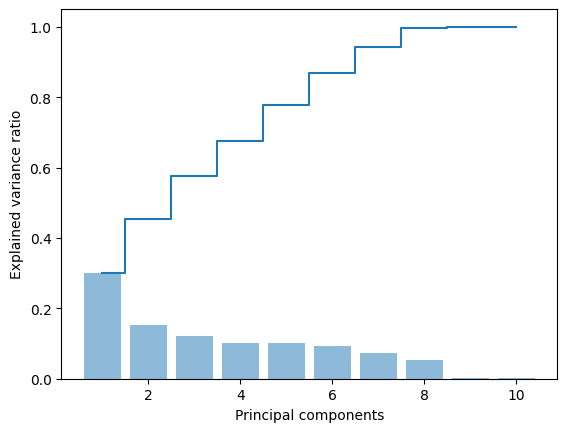

In [4]:
plt.bar(range(1, 11), pca.explained_variance_ratio_, alpha=0.5, align='center')
plt.step(range(1, 11), np.cumsum(pca.explained_variance_ratio_), where='mid')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')

plt.show()

# 2. Pipeline

## 2.1 LR

In [5]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

pipe_lr = Pipeline([('scl', StandardScaler()),
                    ('pca', PCA(n_components=4)),
                    ('lr', LogisticRegression(random_state=1, solver='lbfgs', multi_class='ovr'))])

pipe_lr.fit(x,y)
print('Test Accuracy: %.3f' % pipe_lr.score(x, y))

Test Accuracy: 0.933


## 2.2 SVM

In [6]:
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

# Define SVM Pipeline
pipe_svm = Pipeline([('scl', StandardScaler()),
                         ('pca', PCA(n_components=4)),
                         ('svm', SVC(random_state=1, gamma=0.10, C=0.001))])

pipe_svm.fit(x,y)
print('Test Accuracy: %.3f' % pipe_svm.score(x, y))

Test Accuracy: 0.933


## 2.3 Decision Tree

In [7]:
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

pipe_tree = Pipeline([('scl', StandardScaler()),
                    ('pca', PCA(n_components=4)),
                    ('tree_model', DecisionTreeClassifier(criterion='gini',max_depth=7,random_state=1))])

pipe_tree.fit(x,y)
print('Test Accuracy: %.3f' % pipe_lr.score(x, y))

Test Accuracy: 0.933


# 3. Grid search with 5-fold cross-validation.

## 3.1 LR

In [8]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'pca__n_components': [2, 3, 4, 5],
    'lr__C': [0.1, 1.0, 10.0]  # lr__C refers to the C parameter of Logistic Regression step
}


grid_search = GridSearchCV(estimator=pipe_lr, param_grid=param_grid, scoring='accuracy', cv=5)


grid_search.fit(x, y)

print("Best parameters found: ", grid_search.best_params_)
print("Best accuracy found: %.3f" % grid_search.best_score_)


Best parameters found:  {'lr__C': 0.1, 'pca__n_components': 2}
Best accuracy found: 0.933


## 3.2 SVM

In [9]:
param_grid = {
    'svm__C': [0.01,0.1],
    'svm__gamma': [0.1,1]
}

grid_search = GridSearchCV(estimator=pipe_svm, param_grid=param_grid, scoring='accuracy', cv=5)

grid_search.fit(x, y)

print("Best parameters found: ", grid_search.best_params_)
print("Best accuracy found: %.3f" % grid_search.best_score_)

Best parameters found:  {'svm__C': 0.1, 'svm__gamma': 1}
Best accuracy found: 0.934


## 3.2 Decision Tree

In [10]:
param_grid_tree = {
    'pca__n_components': [2, 3, 4, 5],  
    'tree_model__max_depth': [5, 7, 10], 
}


grid_search_tree = GridSearchCV(estimator=pipe_tree, param_grid=param_grid_tree, scoring='accuracy', cv=5)


grid_search_tree.fit(x, y)


print("Best parameters found: ", grid_search_tree.best_params_)
print("Best accuracy found: %.3f" % grid_search_tree.best_score_)

Best parameters found:  {'pca__n_components': 5, 'tree_model__max_depth': 5}
Best accuracy found: 0.936
